# Task 1: Language model inference

The goal if this first task is to familiarize yourself with the huggingface transformers and dataset libraries. You will learn how to load and tokenize a dataset, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [16]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import XGLMTokenizer, XGLMTokenizerFast, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, GenerationConfig

## Explore dataset

In [17]:
DATA_SET_NAME = "facebook/flores" # specify dataset name
MODEL_NAME = "facebook/xglm-564M" # specify model name
# MODEL_NAME = "gpt2" # specify model name

In [18]:
# Explore a dataset

# covered language codes can be found here: https://github.com/openlanguagedata/flores?tab=readme-ov-file#language-coverage

ds_builder = load_dataset_builder("facebook/flores", "deu_Latn")
print(ds_builder.info.description) # print the dataset description

/CT/Hands2/work/NNTI-project/env_nnti/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.



In [19]:
# print the features (columns) of the dataset
# TODO: your code goes here
ds_builder.info.features

{'id': Value(dtype='int32', id=None),
 'URL': Value(dtype='string', id=None),
 'domain': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None),
 'has_image': Value(dtype='int32', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None)}

In [20]:
# get the available splits
# TODO: your code goes here

get_dataset_split_names("facebook/flores", "deu_Latn")

['dev', 'devtest']

## Load data, tokenize, and batchify

In [21]:
# specify languages
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "ita_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

In [22]:
# load flores data for each language
# TODO: your code goes here
datasets = {}
for lang in LANGUAGES:
    datasets[lang] = load_dataset("facebook/flores", lang)



In [23]:
# let's look at the English subset
# TODO: your code goes here
datasets["eng_Latn"]

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 1012
    })
})

In [24]:
# let's look at an individal sample from the dataset
# TODO: your code goes here
datasets["eng_Latn"]["dev"][0]

{'id': 1,
 'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet',
 'domain': 'wikinews',
 'topic': 'health',
 'has_image': 0,
 'has_hyperlink': 0,
 'sentence': 'On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.'}

In [25]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenization(example):
    # fill in here
    return tokenizer(example["sentence"], padding=True, truncation=True, return_tensors="pt")
    

# TODO: your code goes here
tokenization(datasets["eng_Latn"]["dev"][0:3])

{'input_ids': tensor([[     2,   1504,  28488,      4, 140003,    501,     32, 200884,   6073,
           9512,     48,  88230,  76168,     32, 160597,     48,     11,    929,
          55516,  35761,    155,    490,   9482,  89288,    235,   6950,     13,
             11,  61368,  24049,   2005,  37295,    155,    490,    113, 213481,
             72,   1117,   5885,  86368,   6929, 111288,      7,     73,  59298,
            769,    743,    242,      5,    211,      5,  19015,   5129,      5],
        [     2, 106920, 169914,   2492,    319,   1246,  13470,  15170,     10,
         178985,     48,  21558,      4, 138365,  73517,    219,      4,  31766,
             53,   1253,   5940,     33,  45526,     22,  12740,      8,     95,
          41440,  33504,      4,   2743,     32, 150346,  73401,     73, 102498,
             88,   3234,    157,  74077,  21558,    490,    113,  11135,   2947,
             48,  34300,     64,  33504,      5,      1,      1,      1,      1],
        [   

In [26]:
# let's take a look at a tokenized sample
# TODO: your code goes here
sample = datasets["eng_Latn"]["dev"][2]
tokenized_sample = tokenization(sample)
print(tokenized_sample)

detokenized_sample = tokenizer.decode(tokenized_sample["input_ids"][0])
print(detokenized_sample)



{'input_ids': tensor([[     2,    268,      6, 148232,   4545,    351, 149383,     36,  79708,
            196,  45309,     11,   6544,   5512,     94,   3817,      6,  83690,
            418,   4263,    910, 127783,   1749,  63595,     16,     53, 251134,
             72,      4, 161298,     32,  69601,     33,  37067,  51980,      7,
              5]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
</s> The JAS 39C Gripen crashed onto a runway at around 9:30 am local time (0230 UTC) and exploded, closing the airport to commercial flights.


In [27]:
# construct a pytorch data loader for each dataset
# specify the batch size
BATCH_SIZE = 2 # for testing purposes, we start with a batch size of 2. You can change this later.
dataloaders = {}

# TODO: your code goes here
for lang in LANGUAGES:
    dataloaders[lang] = DataLoader(datasets[lang]["devtest"], batch_size=BATCH_SIZE, shuffle=True)


## Load model

In [28]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [29]:
device

'cuda:1'

In [30]:
# load pre-trained model from the huggingface hub
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# put the model into evaluation mode
# TODO: your code goes here
model.eval()


XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 1024, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [31]:
import torch

In [32]:
from tqdm.notebook import tqdm

In [33]:
losses = {lang: [] for lang in LANGUAGES} # store per-batch losses for each language

# iterate over the datset for each language and compute the cross-entropy loss per batch 
# TODO: your code goes here

with torch.no_grad():
    model.to(device)
    for lang in LANGUAGES:
        print(lang)
        for batch in tqdm(dataloaders[lang]):
            batch = tokenization(batch)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # labels = batch["input_ids"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            losses[lang].append(loss.item())

            del input_ids
            del attention_mask


eng_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/506 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/506 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/506 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

## Visualize loss per language

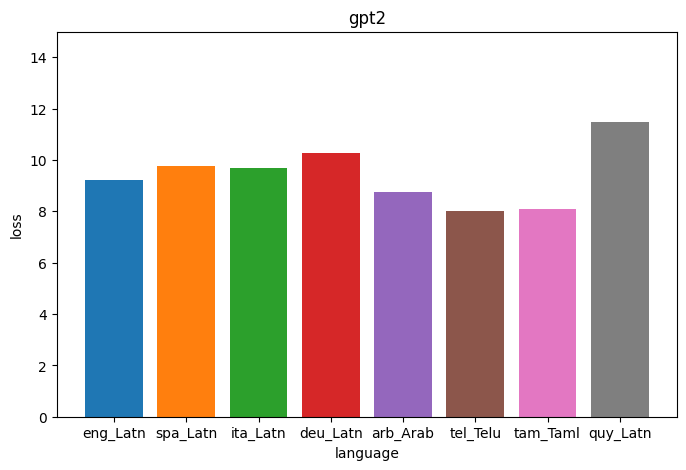

In [45]:
# create a figure
fig, axes = plt.subplots(figsize=(8, 5))

# create a bar plot for each langauge
# TODO: your code goes here
for i, lang in enumerate(LANGUAGES):
    axes.bar(i, np.mean(losses[lang]))

# format plot
axes.set_xlabel("language") # x-axis label
axes.set_xticks(range(len(LANGUAGES))) # x-axis ticks
axes.set_xticklabels(losses.keys()) # x-axis tick labels
axes.set_ylabel("loss") # y-axis label
axes.set_ylim(0, 15) # range of y-axis
axes.set_title(MODEL_NAME); # title

In [40]:
import json
json.dump(losses, open("losses_xglm.json", "w"))

## Comparing XGLM to GPT2

Your next task is to re-run the analysis above, but using `gpt2` as the pre-trained language model. For this exercise, focus on your native language, unless it's English or isn't covered by flores. In that case, pick another language that you can read well. 

Compare the language modeling loss of XGLM and GPT2. What do you observe? Investigate the differences in tokenization for XGLM and GPT2. What do you observe? How can the good (or bad) performance of GPT2 be explained?

In [41]:
torch.cuda.empty_cache()

In [42]:
# TODO: your code goes here
MODEL_NAME = "gpt2" # specify model name

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})


#load model
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval()

# iterate for each language and compute the cross-entropy loss per batch
losses_gpt2 = {lang: [] for lang in LANGUAGES} # store per-batch losses for each language

with torch.no_grad():
    model.to(device)
    for lang in LANGUAGES:
        print(lang)
        for batch in tqdm(dataloaders[lang]):
            batch = tokenization(batch)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # labels = batch["input_ids"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            losses_gpt2[lang].append(loss.item())

            del input_ids
            del attention_mask




tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

eng_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

spa_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

ita_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

deu_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

arb_Arab


  0%|          | 0/506 [00:00<?, ?it/s]

tel_Telu


  0%|          | 0/506 [00:00<?, ?it/s]

tam_Taml


  0%|          | 0/506 [00:00<?, ?it/s]

quy_Latn


  0%|          | 0/506 [00:00<?, ?it/s]

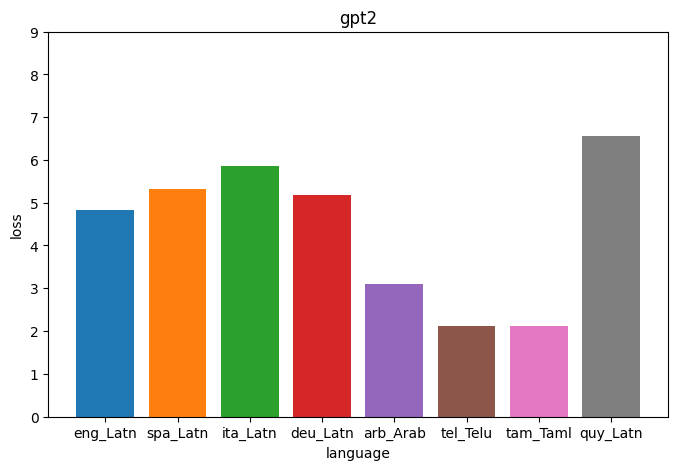

In [44]:
# create a figure
fig, axes = plt.subplots(figsize=(8, 5))

# create a bar plot for each langauge
# TODO: your code goes here
for i, lang in enumerate(LANGUAGES):
    axes.bar(i, np.mean(losses_gpt2[lang]))

# format plot
axes.set_xlabel("language") # x-axis label
axes.set_xticks(range(len(LANGUAGES))) # x-axis ticks
axes.set_xticklabels(losses_gpt2.keys()) # x-axis tick labels
axes.set_ylabel("loss") # y-axis label
axes.set_ylim(0, 9) # range of y-axis
axes.set_title(MODEL_NAME); # title

In [46]:
# save the losses to a file
json.dump(losses_gpt2, open("losses_gpt2.json", "w"))